# Questions

## Increase in surface salinity in the arctic, is there some kind of trend in obersved data? What about models?

## How well does models represent the changes in salinity, and can they be used as a good indication for the future?

## How does sea surface salinity affect the vertical ocean circulation? And is this influence impactfull?

## What can we say about the sea surface salinity in the future, and how will this affect the vertical circulation in the arctic?


The Arctic has a greater temperature increase than other parts of the world because of arctic amplification [reference]. 

In [1]:
import functions as f
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import s3fs
import cftime
import intake
import numpy as np
from joblib import Parallel, delayed
from pyproj import Transformer
from datetime import datetime
import s3fs
%load_ext autoreload
%autoreload 2
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))

## Satellite data

In [2]:
import time
path='escience2022/Antoine/ESA_SMOS_Arctic_Sea_Surface_Salinity/'
years = [2011,2012,2013,2014,2015,2016,2017,2018,2019]
start = time.time()
sat_data = f.collect_satellite_data(years, path)
print(time.time()-start)

231.06332921981812


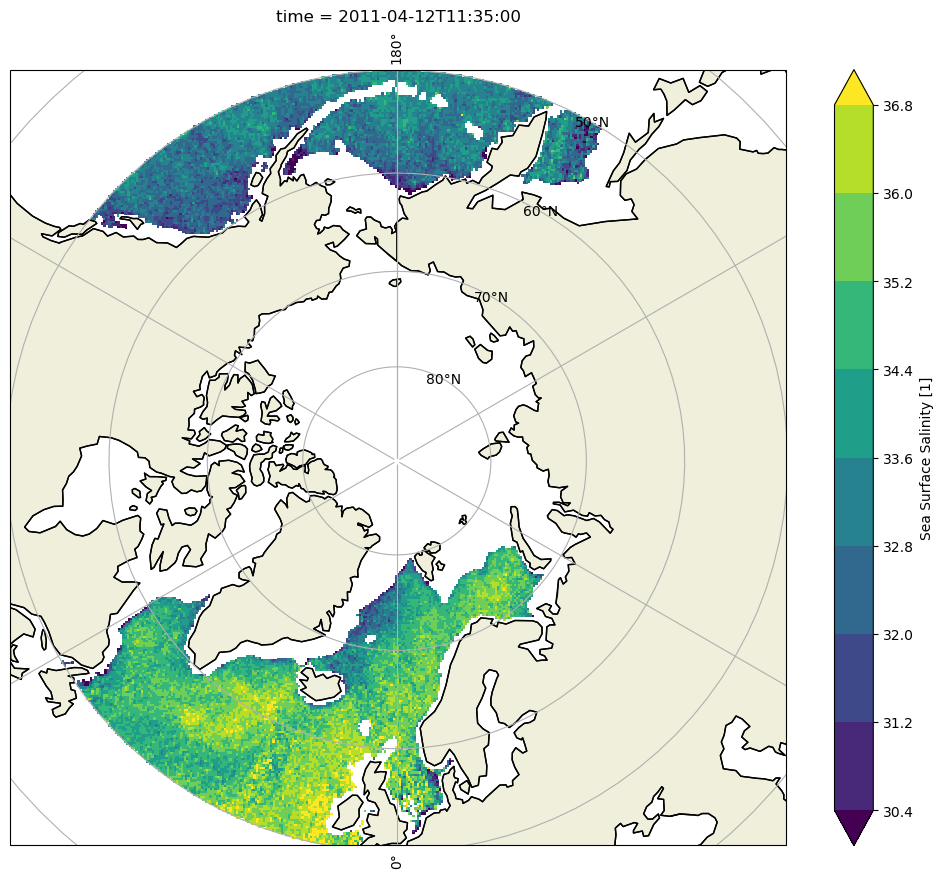

In [3]:
f.plot_sss_sat(sat_data['sss'][100])

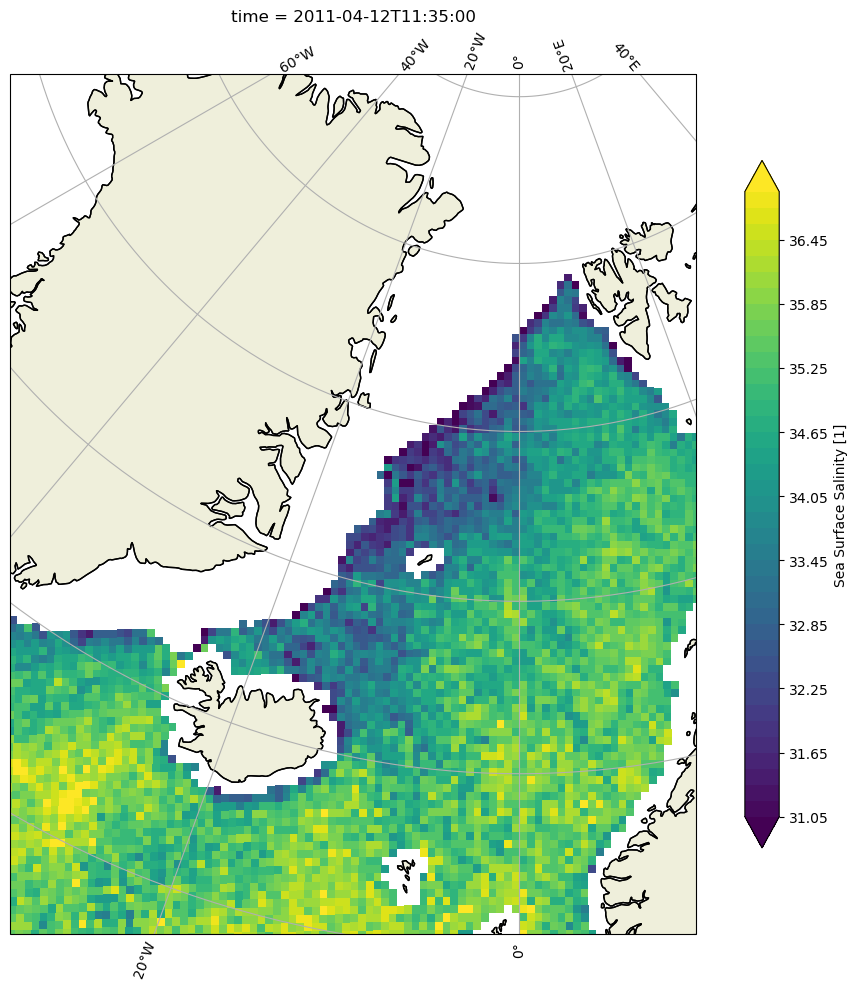

In [4]:
f.plot_sss_sat(sat_data['sss'][100], levels=50, extent=[-30,10,85,60], vmin=10, vmax=40)

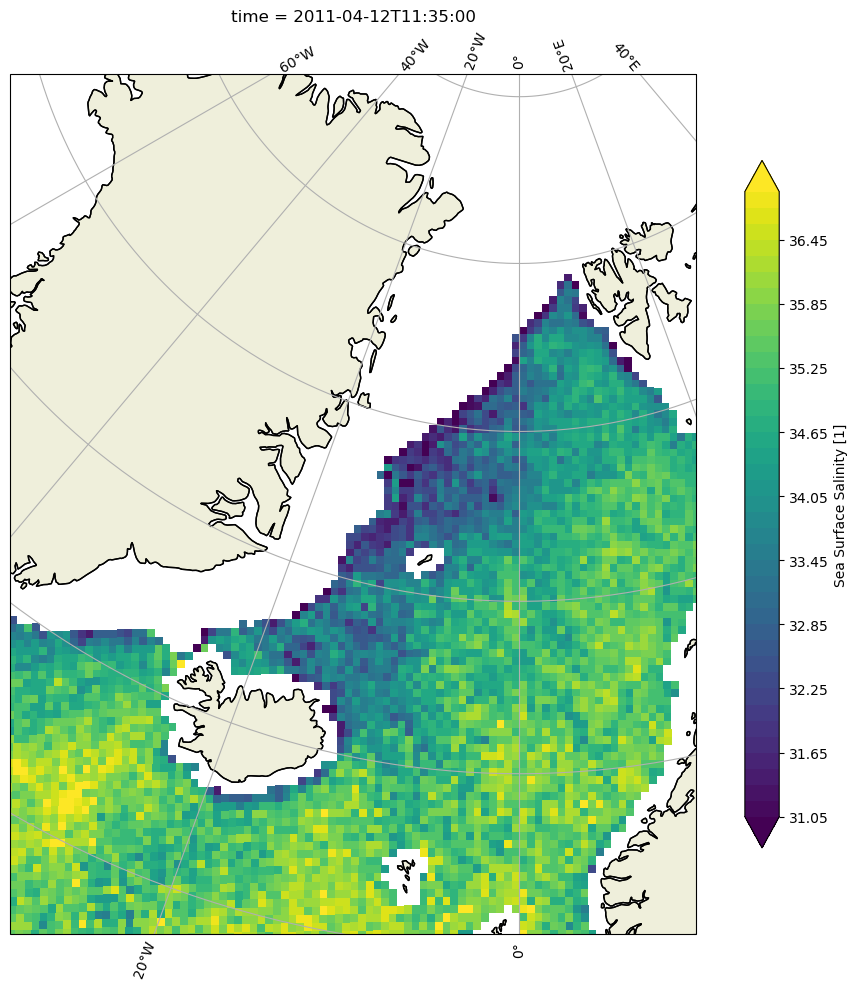

In [5]:
f.plot_sss_sat(sat_data['sss'][100], extent=[-30,10,85,60], levels=50, vmin=10, vmax=40)

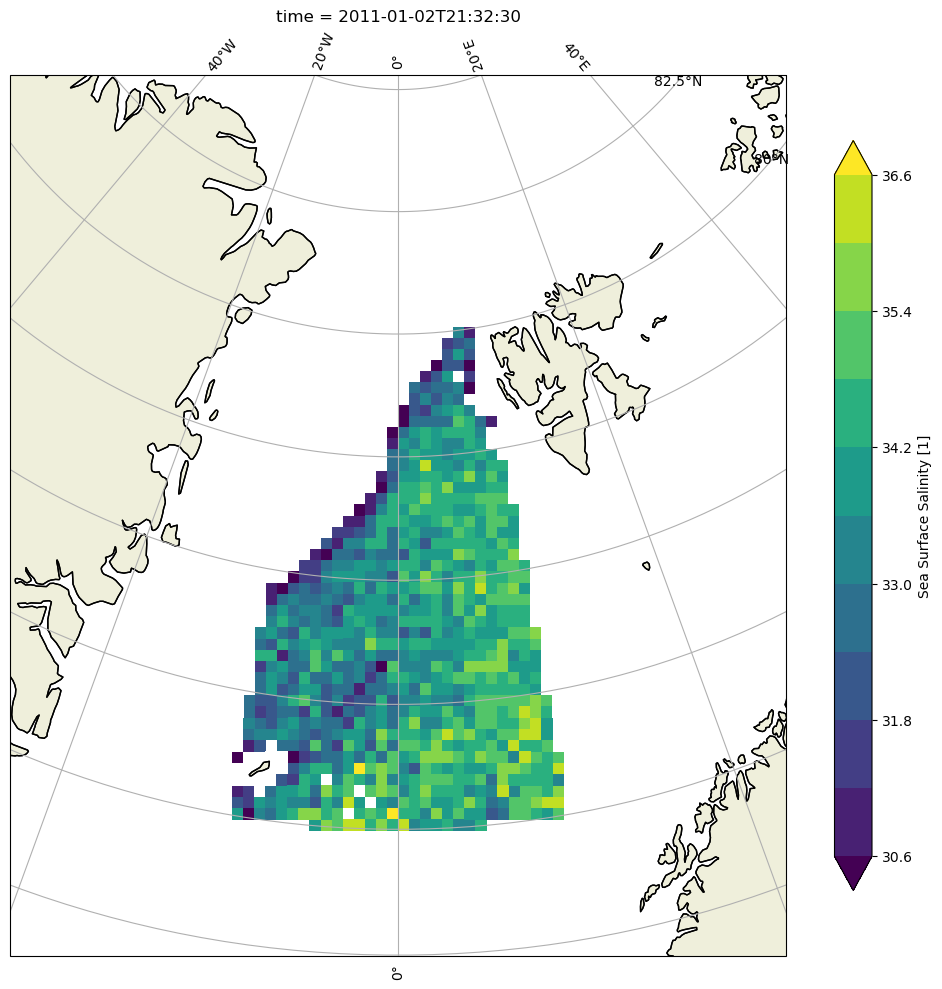

In [29]:

SatRegion1 = f.slice_data(sat_data, '2009-01-01', '2022-02-01', -10, 10, 70, 85)

min_lat = np.min(SatRegion1['lat'])
min_lon = (np.min(SatRegion1['lon'][0]))
max_lat = np.max(SatRegion1['lat'])
max_lon = np.max(SatRegion1['lon'][0])

#SatRegion1 = SatRegion1.where(SatRegion1['lat']-(SatRegion1['lon']/2) > min(min_lat-min_lon/2-1, max_lat-max_lon/2-1), drop=True)

f.plot_sss_sat(SatRegion1['sss'][0], extent = [-20,20,67,85])

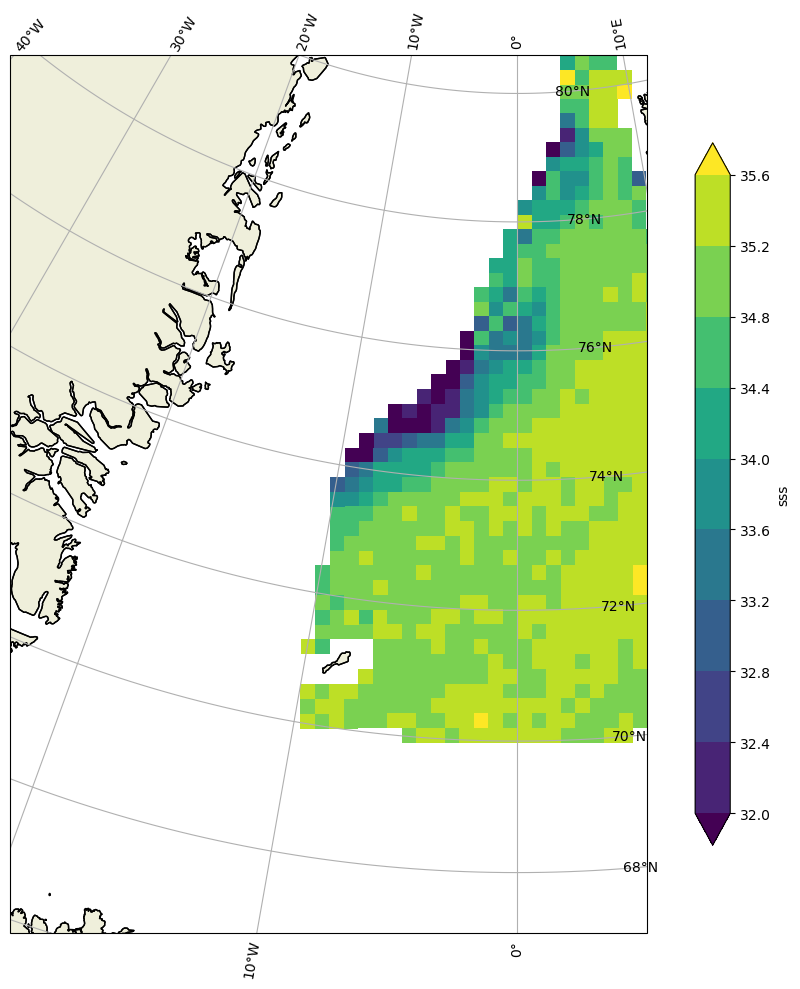

In [30]:
month = SatRegion1['time.month']
year = SatRegion1['time.year']
SatRegion1MeanJA = SatRegion1.where((month.isin(1)) & (year.isin(2013))).mean('time')
SatRegion1MeanJA['sss'].mean()
f.plot_sss_sat(SatRegion1MeanJA['sss'], extent = [-20,5,67,80])

## Seasonality

In [31]:
month = SatRegion1['time.month']
year = SatRegion1['time.year']
mean_list = []
for y in [2012,2013,2014,2015,2016,2017,2018,2019]:
    for m in [1,2,3,4,5,6,7,8,9,10,11,12]:
        tmp = SatRegion1.where((month.isin(m)) & (year.isin(y))).mean('time')
        mean_list.append(tmp['sss'].mean())

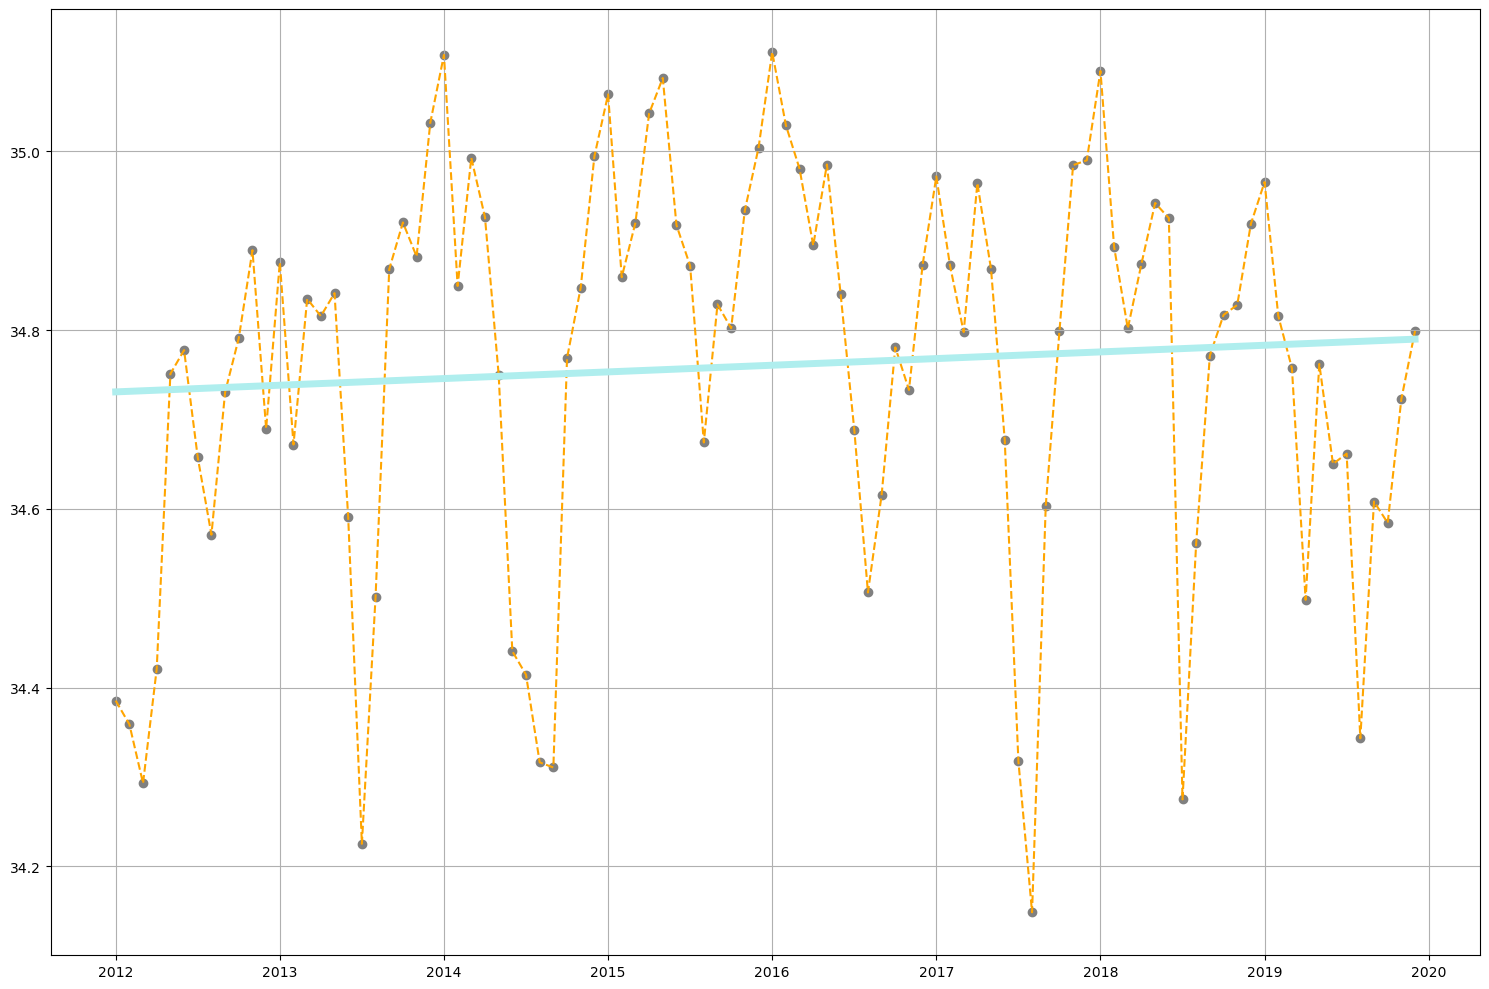

In [32]:
from scipy import stats
x = np.arange(0,12*8, 1)
ticks = [0,12,24,36,48,60,72,84,96]
dic = { 0:'2012', 12:'2013', 24:'2014', 36:'2015', 48:'2016', 60:'2017', 72:'2018', 84:'2019', 96:'2020'}
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]

res = stats.linregress(x, mean_list)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(x, mean_list, '--', color='orange')
plt.scatter(x,mean_list, color='gray')
plt.plot(x, res.intercept + res.slope*x, color='paleturquoise', lw=5)
ax.set_xticks(ticks)

ax.set_xticklabels(labels)
plt.tight_layout()
plt.grid()

In [33]:
"""
SatRegion1 = f.slice_data(sat_data, '2009-01-01', '2022-02-01', -20, 5, 67, 80)

MeanSat = SatRegion1['sss'].groupby('time.month').mean('time').mean('x').mean('y').compute()
s = SatRegion1['sss'].mean('x').mean('y').compute().groupby('time.month')

#area['so'].groupby('time.month').mean(dim='time').mean('i').mean('j').compute()
#t = area['so'].mean('i').mean('j').compute().groupby('time.month')
"""

"\nSatRegion1 = f.slice_data(sat_data, '2009-01-01', '2022-02-01', -20, 5, 67, 80)\n\nMeanSat = SatRegion1['sss'].groupby('time.month').mean('time').mean('x').mean('y').compute()\ns = SatRegion1['sss'].mean('x').mean('y').compute().groupby('time.month')\n\n#area['so'].groupby('time.month').mean(dim='time').mean('i').mean('j').compute()\n#t = area['so'].mean('i').mean('j').compute().groupby('time.month')\n"

In [34]:
"""
x = np.arange(1,13)

fig, ax = plt.subplots()
max_ = []
min_ = []

for month in s.groups.keys():
    max_.append(np.max(s[month]))
    min_.append(np.min(s[month]))
ax.fill_between(x, min_, max_, color='seashell')
for month in s.groups.keys():
    m = np.full(len(s[month]), month)
    plt.scatter(m, s[month], color='peachpuff')
    
plt.plot(x, MeanSat, color='cadetblue', lw = 5)
dic = { 1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
ticks = [1,2,3,4,5,6,7,8,9,10,11,12]
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
plt.grid()
plt.show()
#del(MeanSat)
#del(s)
#del(SatRegion1)
#Higher frequency, daily graph instead of monthly mean
"""

"\nx = np.arange(1,13)\n\nfig, ax = plt.subplots()\nmax_ = []\nmin_ = []\n\nfor month in s.groups.keys():\n    max_.append(np.max(s[month]))\n    min_.append(np.min(s[month]))\nax.fill_between(x, min_, max_, color='seashell')\nfor month in s.groups.keys():\n    m = np.full(len(s[month]), month)\n    plt.scatter(m, s[month], color='peachpuff')\n    \nplt.plot(x, MeanSat, color='cadetblue', lw = 5)\ndic = { 1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}\nticks = [1,2,3,4,5,6,7,8,9,10,11,12]\nlabels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]\nax.set_xticks(ticks)\nax.set_xticklabels(labels)\nplt.grid()\nplt.show()\n#del(MeanSat)\n#del(s)\n#del(SatRegion1)\n#Higher frequency, daily graph instead of monthly mean\n"

In [35]:

MeanSat = SatRegion1['sss'].groupby('time.dayofyear').mean('time').mean('x').mean('y').compute()
s = SatRegion1['sss'].mean('x').mean('y').compute().groupby('time.dayofyear')
StdSat = SatRegion1['sss'].groupby('time.dayofyear').std('time').std('x').std('y').compute()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


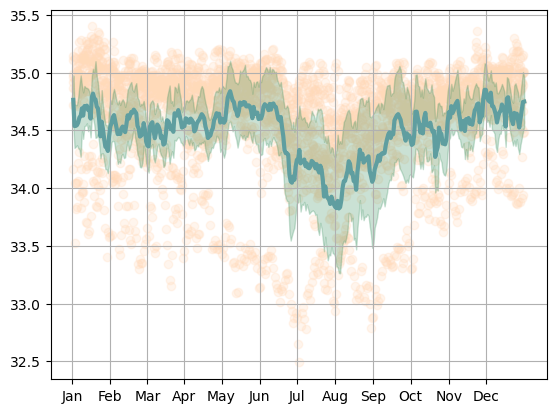

In [36]:
x = np.arange(1,367)

fig, ax = plt.subplots()
max_ = []
min_ = []
for month in s.groups.keys():
    m = np.full(len(s[month]), month)
    plt.scatter(m, s[month], color='peachpuff', alpha=0.25)
ax.fill_between(x, MeanSat-StdSat, MeanSat+StdSat, color='seagreen', alpha=0.25)


plt.plot(x, MeanSat, color='cadetblue', lw = 3)

dic = { 0:'Jan', 31:'Feb', 61:'Mar', 91:'Apr', 121:'May', 152:'Jun', 182:'Jul', 213:'Aug', 244:'Sep', 274:'Oct', 305:'Nov', 335:'Dec'}
ticks = [0,31,61,91,121,152,182,213,244,274,305,335]
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
plt.grid()
plt.show()

#We se a clear seasonal variation which follows the ice melt.
#Some variability during the season, mostly during the same time period as the ice melts. Different temperatures each year ----> different amount of fresh water flux from ice melt

## Correlation with ice concentration

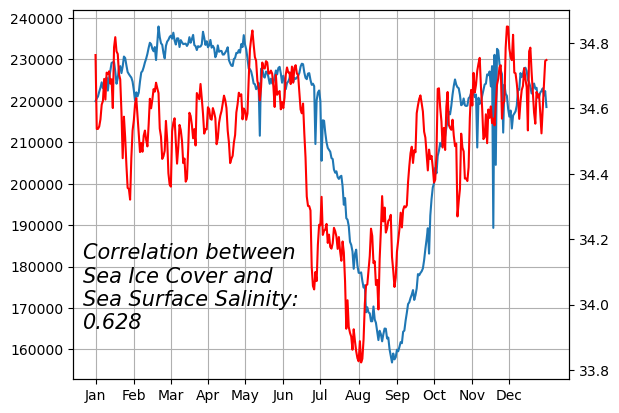

In [37]:
ice_path = 'AMSR2_E_Daily sea ice extent_GL sea.nc'
ice_ds = xr.open_dataset(ice_path)

MeanIceDaily = ice_ds['z'].groupby('time.dayofyear').mean('time').compute()
STDIceDaily = ice_ds['z'].groupby('time.dayofyear').std('time').compute()

x = np.arange(366)
fig, ax = plt.subplots()
ax1 = ax.twinx()
#ax.fill_between(x, MeanIceDaily+STDIceDaily, MeanIceDaily-STDIceDaily, color='seashell')
#ax1.fill_between(x, MeanSat-StdSat, MeanSat+StdSat, color='seashell')
ax.plot(x, MeanIceDaily)

ax1.plot(x, MeanSat, 'r')
dic = { 0:'Jan', 31:'Feb', 61:'Mar', 91:'Apr', 121:'May', 152:'Jun', 182:'Jul', 213:'Aug', 244:'Sep', 274:'Oct', 305:'Nov', 335:'Dec'}
ticks = [0,31,61,91,121,152,182,213,244,274,305,335]
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
corr = np.corrcoef(MeanIceDaily, MeanSat)[0,1]
ax.text(-10, 165000, f'Correlation between \nSea Ice Cover and \nSea Surface Salinity:\n{corr:.3f}', style ='italic',
        fontsize = 15, color ="black")
ax.grid()
plt.show()


#SeaIceCover
#When Sea Ice melts, it will become thinner in the beginning, but will still cover the ocean
#this means that while the sea ice extent does not get much smaller, it becomes thinner, so we have a freshwater input into the ocean, meaning that salinity should decrease

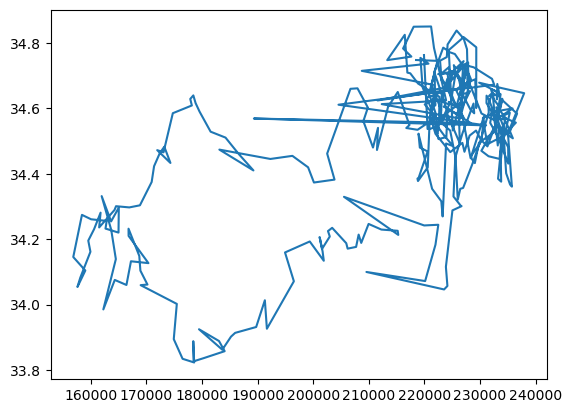

In [38]:
plt.plot(MeanIceDaily, MeanSat)

#Circular means lag in the signal, one that increases and then second one increases

## ARGO data

In [30]:
_id = '3901591'
_id2 = '3901620'
argo_path = f's3://escience2022/Ada/ARGO/coriolis/{_id}/{_id}_prof.nc'
argo_path2 = f's3://escience2022/Ada/ARGO/coriolis/{_id2}/{_id2}_prof.nc'

In [161]:
Argo1 = xr.open_dataset(s3.open(argo_path))
Argo2 = xr.open_dataset(s3.open(argo_path2))
Argo1

<xarray.Dataset>
Dimensions:                       (N_PROF: 65, N_PARAM: 3, N_LEVELS: 80,
                                   N_CALIB: 1)
Dimensions without coordinates: N_PROF, N_PARAM, N_LEVELS, N_CALIB
Data variables: (12/52)
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    ...                            ...
    PSAL_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    PARAMETER                     (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_EQUATION     (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_COEFFICIENT  (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_COMMENT      (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_DATE         (N_PROF, N_CALIB, N_PARAM) object ...
Attributes:
    title:                Argo float aggregated multi-cycle profile
    institution:          US GDAC
    source:               Argo float
    history:              2019-07-02T02:00:05Z
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  3.1
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile

In [162]:
Argo1.JULD

<xarray.DataArray 'JULD' (N_PROF: 65)>
array(['2016-08-24T00:35:18.000002816', '2016-09-03T00:36:53.999995136',
       '2016-09-12T22:51:59.000001536', '2016-09-22T23:08:11.000000000',
       '2016-10-03T00:35:46.999996416', '2016-10-12T23:01:21.999995392',
       '2016-10-23T00:36:40.000000768', '2016-11-01T23:07:09.999998976',
       '2016-11-12T00:35:27.000004352', '2016-11-21T23:03:51.000002048',
       '2016-12-02T00:34:56.999996160', '2016-12-11T23:16:37.999995904',
       '2016-12-22T00:43:31.999998976', '2016-12-31T22:58:38.000000000',
       '2017-01-11T00:39:30.999998464', '2017-01-20T22:56:00.000002048',
       '2017-01-31T00:43:54.000000256', '2017-02-09T23:03:10.999997696',
       '2017-02-20T00:41:59.000000512', '2017-03-01T22:53:33.999999232',
       '2017-03-12T00:36:34.000003072', '2017-03-21T23:07:46.000004864',
       '2017-04-10T22:18:56.999999744', '2017-04-20T22:09:57.000001792',
       '2017-05-10T22:12:55.999996416', '2017-05-20T22:27:02.000004352',
       '2017-05-30T22:13:06.999996928', '2017-06-09T22:18:49.000002816',
       '2017-06-19T22:15:23.999998208', '2017-06-29T22:12:42.000001792',
       '2017-07-09T22:27:30.000003328', '2017-07-19T22:28:59.000003328',
       '2017-07-29T22:42:22.999997696', '2017-08-08T22:53:39.999996928',
       '2017-08-18T22:53:46.000004608', '2017-08-28T23:09:15.999999488',
       '2017-09-07T23:05:51.000004864', '2017-09-17T23:21:20.999999744',
       '2017-09-28T00:51:45.000000256', '2017-10-07T23:23:38.000001024',
       '2017-10-18T00:44:14.000002560', '2017-10-27T23:09:06.999997952',
       '2017-11-07T00:41:36.999998976', '2017-11-16T23:16:18.999998464',
       '2017-11-27T00:39:41.999999232', '2017-12-06T23:39:36.000004864',
       '2017-12-17T00:41:59.000000512', '2017-12-26T23:25:05.000001792',
       '2018-01-06T00:49:53.000004352', '2018-01-15T23:11:57.999995904',
       '2018-01-26T00:44:27.999996928', '2018-02-04T23:06:32.999998464',
       '2018-02-15T00:43:57.000004096', '2018-02-24T23:03:14.999996160',
       '2018-03-07T00:45:32.000001792', '2018-03-16T23:05:31.999997440',
       '2018-03-27T00:40:07.000004352', '2018-04-05T23:09:54.999999232',
       '2018-04-16T00:41:01.000003328', '2018-04-25T23:03:06.000004608',
       '2018-05-06T00:42:36.000001024', '2018-05-15T22:56:59.999998464',
       '2018-05-26T00:44:10.999998720', '2018-06-04T23:25:53.000003072',
       '2018-06-15T00:47:51.999996928'], dtype='datetime64[ns]')
Dimensions without coordinates: N_PROF
Attributes:
    long_name:      Julian day (UTC) of the station relative to REFERENCE_DAT...
    standard_name:  time
    conventions:    Relative julian days with decimal part (as parts of day)
    resolution:     1.1574074074074073e-05
    axis:           T

<xarray.DataArray 'LONGITUDE' (N_PROF: 65)>
array([-3.319, -2.87 , -3.022, -3.454, -3.745, -4.11 , -5.259, -4.84 , -5.034,
       -5.629, -4.8  , -3.138, -2.791, -2.795, -3.915, -4.678, -5.123, -5.45 ,
       -5.588, -6.088, -7.219, -8.185, -9.061, -8.875, -7.643, -5.051, -0.445,
        0.301, -2.278, -2.567, -3.53 , -3.511, -4.175, -4.986, -3.915, -4.559,
       -5.792, -5.58 , -4.482, -5.109, -5.237, -5.217, -6.139, -6.304, -5.505,
       -2.889, -1.968, -0.708, -1.132, -1.564, -2.476, -2.27 , -2.004, -1.446,
       -2.764, -4.253, -4.197, -4.786, -6.34 , -5.876, -5.531, -4.299, -6.907,
       -7.678, -7.296])
Dimensions without coordinates: N_PROF
Attributes:
    long_name:      Longitude of the station, best estimate
    standard_name:  longitude
    units:          degree_east
    valid_min:      -180.0
    valid_max:      180.0
    axis:           X
<xarray.DataArray 'LATITUDE' (N_PROF: 65)>
array([73.973, 74.047, 74.099, 74.413, 74.464, 74.416, 74.447, 74.454, 74.407,
       74

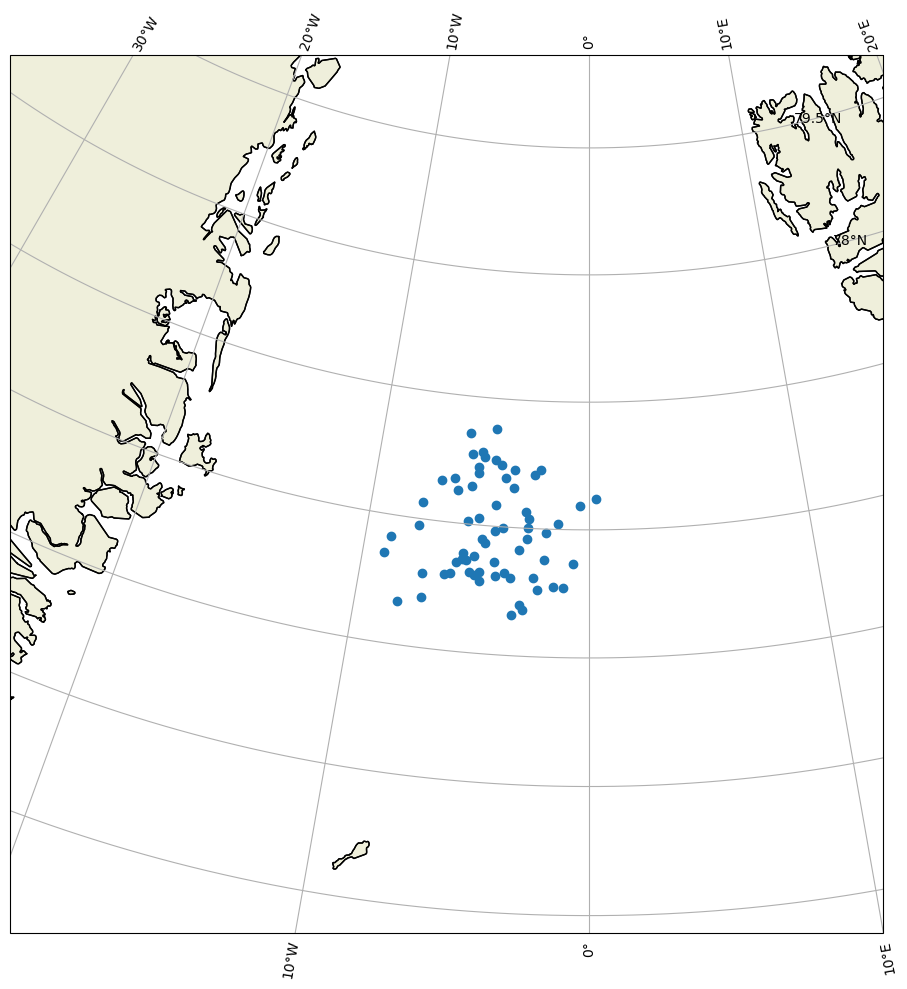

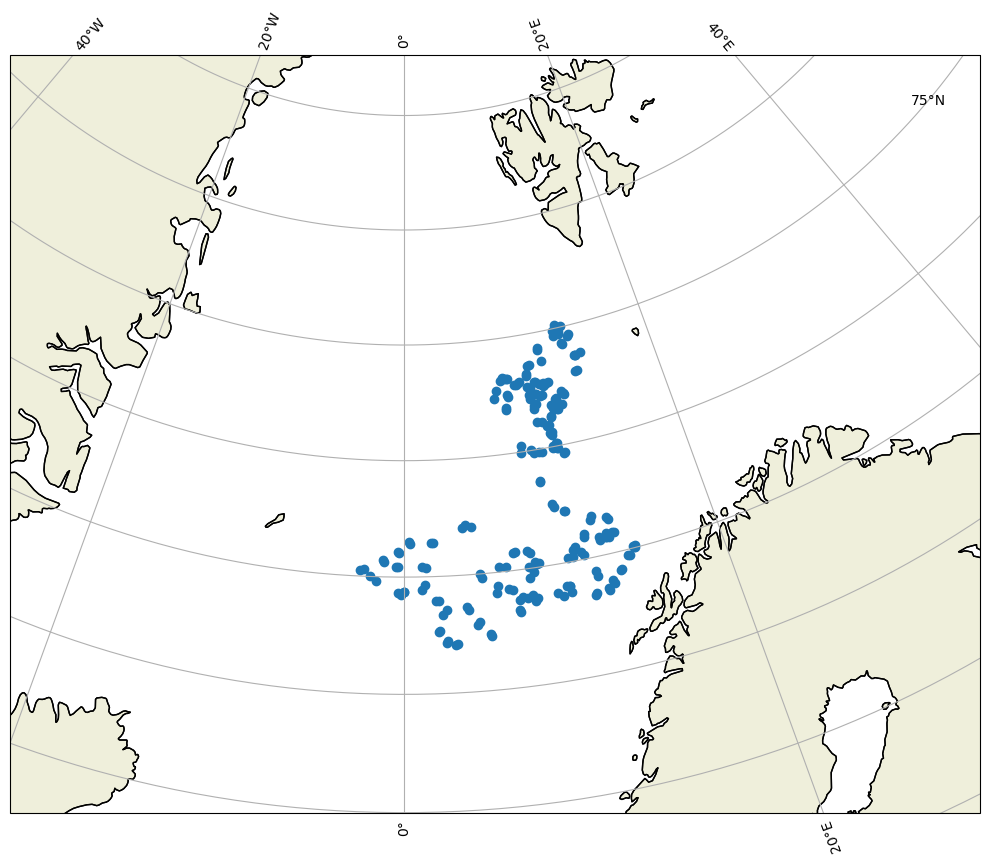

In [34]:
f.plot_argo_positions(Argo1, extent=[-20,10,80,70])
f.plot_argo_positions(Argo2, extent=[-20,30,80,65])
print(Argo1['LONGITUDE'])
print(Argo1['LATITUDE'])

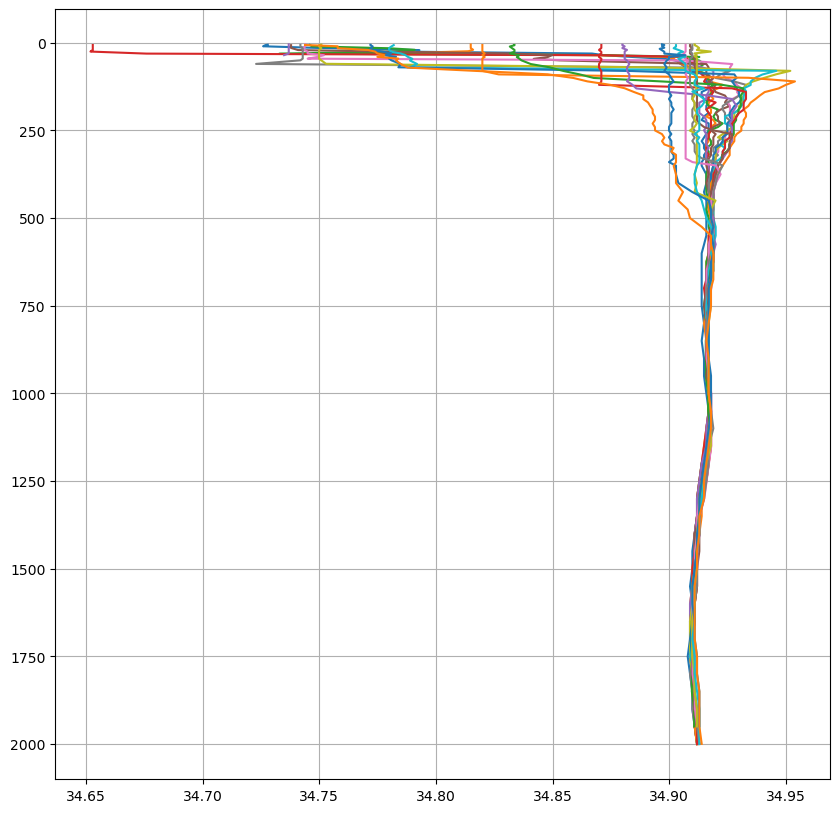

In [102]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(30):
    plt.plot(Argo1['PSAL_ADJUSTED'][i], Argo1['PRES'][i])
    #plt.plot(Argo2['PSAL_ADJUSTED'][i], Argo2['PRES'][i])
plt.gca().invert_yaxis()
ax.grid()

## Model data

In [3]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(variable_id='so', source_id='UKESM1-0-LL', activity_id='CMIP', experiment_id='historical')
cat2 = col.search(variable_id='areacello', source_id='UKESM1-0-LL')
# Check for omip
cat.df

activity_id institution_id    source_id experiment_id  member_id table_id  \
0         CMIP           MOHC  UKESM1-0-LL    historical   r6i1p1f3     Omon   
1         CMIP           MOHC  UKESM1-0-LL    historical   r1i1p1f2     Omon   
2         CMIP           MOHC  UKESM1-0-LL    historical   r8i1p1f2     Omon   
3         CMIP           MOHC  UKESM1-0-LL    historical   r4i1p1f2     Omon   
4         CMIP           MOHC  UKESM1-0-LL    historical   r3i1p1f2     Omon   
5         CMIP           MOHC  UKESM1-0-LL    historical   r2i1p1f2     Omon   
6         CMIP           MOHC  UKESM1-0-LL    historical   r7i1p1f3     Omon   
7         CMIP           MOHC  UKESM1-0-LL    historical   r9i1p1f2     Omon   
8         CMIP           MOHC  UKESM1-0-LL    historical  r17i1p1f2     Omon   
9         CMIP           MOHC  UKESM1-0-LL    historical  r19i1p1f2     Omon   
10        CMIP           MOHC  UKESM1-0-LL    historical  r18i1p1f2     Omon   
11        CMIP           MOHC  UKESM1-0-LL    historical  r11i1p1f2     Omon   
12        CMIP           MOHC  UKESM1-0-LL    historical  r16i1p1f2     Omon   
13        CMIP           MOHC  UKESM1-0-LL    historical  r12i1p1f2     Omon   
14        CMIP           MOHC  UKESM1-0-LL    historical  r10i1p1f2     Omon   
15        CMIP           MOHC  UKESM1-0-LL    historical   r5i1p1f3     Omon   
16        CMIP       NIMS-KMA  UKESM1-0-LL    historical  r13i1p1f2     Omon   

   variable_id grid_label                                             zstore  \
0           so         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...   
1           so         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...   
2           so         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...   
3           so         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...   
4           so         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...   
5           so         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...   
6           so         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...   
7           so         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...   
8           so         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...   
9           so         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...   
10          so         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...   
11          so         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...   
12          so         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...   
13          so         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...   
14          so         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...   
15          so         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...   
16          so         gn  gs://cmip6/CMIP6/CMIP/NIMS-KMA/UKESM1-0-LL/his...   

    dcpp_init_year   version  
0              NaN  20190604  
1              NaN  20190627  
2              NaN  20190708  
3              NaN  20190708  
4              NaN  20190708  
5              NaN  20190708  
6              NaN  20191011  
7              NaN  20191015  
8              NaN  20191115  
9              NaN  20191119  
10             NaN  20191119  
11             NaN  20191209  
12             NaN  20191209  
13             NaN  20191210  
14             NaN  20191213  
15             NaN  20200124  
16             NaN  20200805

In [4]:
cat2.df

activity_id institution_id    source_id experiment_id member_id table_id  \
0        CMIP           MOHC  UKESM1-0-LL     piControl  r1i1p1f2      Ofx   

  variable_id grid_label                                             zstore  \
0   areacello         gn  gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/piContr...   

   dcpp_init_year   version  
0             NaN  20190705

In [5]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})#.mean(member_id)   OR SOMETHING LIKE THIS, FIGURE IT OUT
dset_dict2 = cat2.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [13]:



#si = dsi_dict[list(dsi_dict.keys())[0]]
#si_mean = si['siconc'].mean(dim = ['member_id'], keep_attrs=True)

MDS = dset_dict[list(dset_dict.keys())[0]]
#ModelDataList = list(dset_dict.keys())
ModelDataList2 = list(dset_dict2.keys())
#MDS = dset_dict[ModelDataList[0]].squeeze()
MDS = MDS.mean('member_id', keep_attrs=True)
#areacello = dset_dict2[ModelDataList2[0]].squeeze()
#MDS = MDS['so'].mean('member_id', keep_attrs=True)
#mds = MDS.sel(time='2010-10').sel(bnds=0).sel(lev=1, method='nearest').sel(vertices=0).squeeze()
MDS
mds = MDS.sel(time='2010-10').sel(bnds=0).sel(lev=1, method='nearest').sel(vertices=0).squeeze()
mds

<xarray.Dataset>
Dimensions:             (i: 362, j: 332)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 355 356 357 358 359 360 361
  * j                   (j) int32 0 1 2 3 4 5 6 ... 325 326 327 328 329 330 331
    latitude            (j, i) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    lev                 float64 0.5058
    lev_bnds            float64 dask.array<chunksize=(), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    time                object 2010-10-16 00:00:00
    time_bnds           object dask.array<chunksize=(), meta=np.ndarray>
Data variables:
    so                  (j, i) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    vertices_latitude   (j, i) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    vertices_longitude  (j, i) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
Attributes: (12/52)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    cmor_version:            3.4.0
    ...                      ...
    variable_name:           so
    variant_label:           r13i1p1f2
    netcdf_tracking_ids:     hdl:21.14100/b499c8b0-2082-43db-a178-90cb7d23afd...
    version_id:              v20200805
    intake_esm_varname:      ['so']
    intake_esm_dataset_key:  CMIP.NIMS-KMA.UKESM1-0-LL.historical.Omon.gn

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


NameError: name 'areacello' is not defined

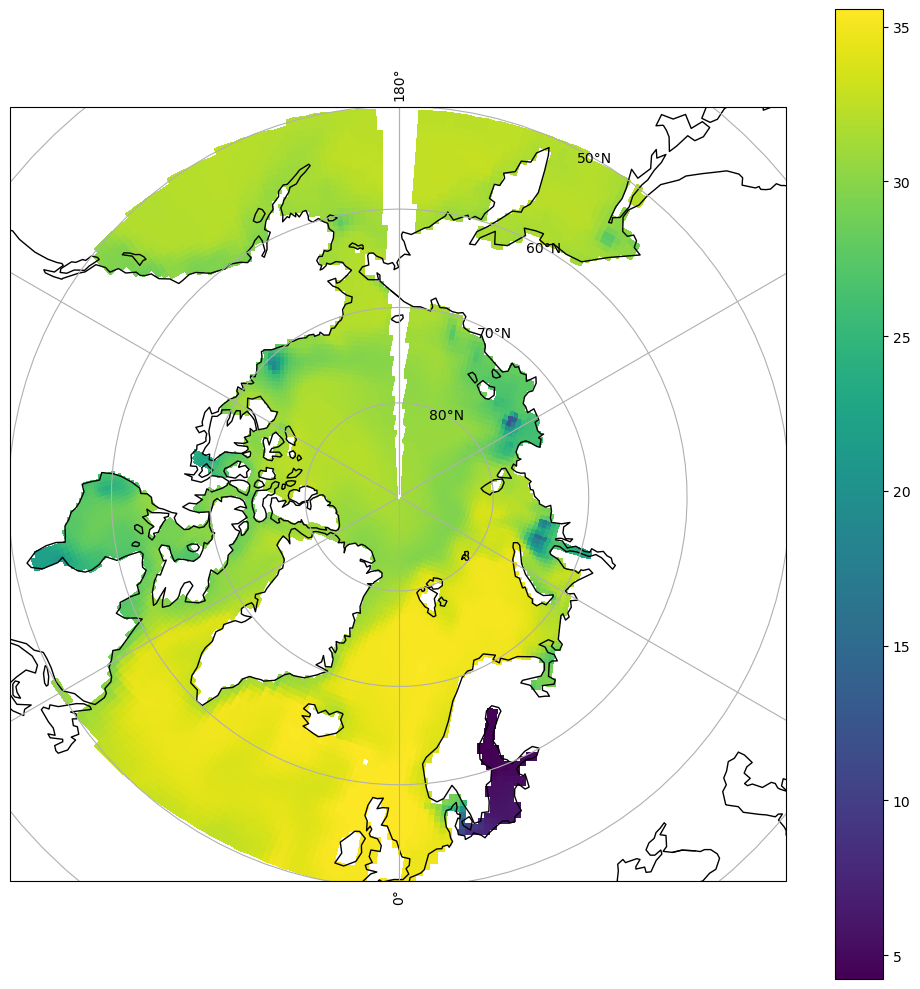

In [14]:
cut = f.slice_data(mds, min_lat = 50, max_lat = 90, min_lon = -177, max_lon = 177)
f.PlotModel(cut, [-177,177,90,50])
areacello.areacello

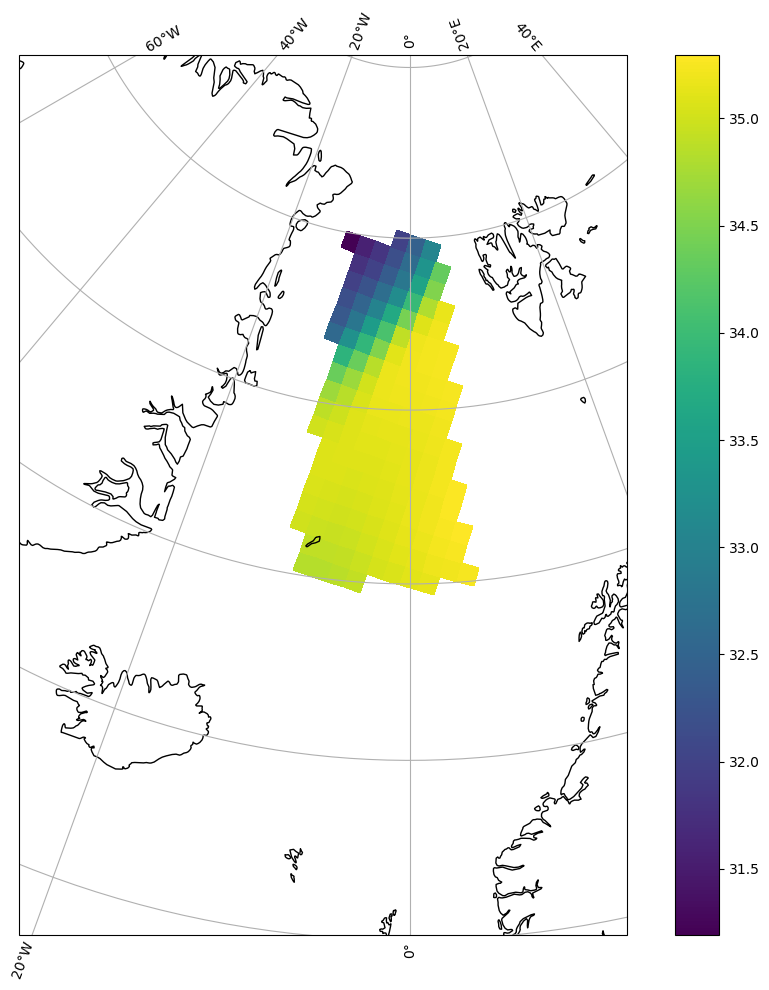

In [41]:
#-10, 10, 70, 85

cut = f.slice_data(cut, min_lat = 70, max_lat = 85, min_lon = -10, max_lon = 10)
f.PlotModel(cut, extent=[-22,12,60,85])

In [42]:
area = MDS.sel(time = slice('1980','2020')).sel(lev=0, method='nearest').sel(bnds=0).sel(vertices=0)
area = f.slice_data(area, min_lat = 70, max_lat = 85, min_lon = -10, max_lon = 10)

min_lat = np.min(area['latitude'])
min_lon = (np.min(area['longitude'][0]))
max_lat = np.max(area['latitude'])
max_lon = np.max(area['longitude'][0])

#area = area.where(area['latitude']-(area['longitude']/2) > min(min_lat-min_lon/2-1, max_lat-max_lon/2-1), drop=True)

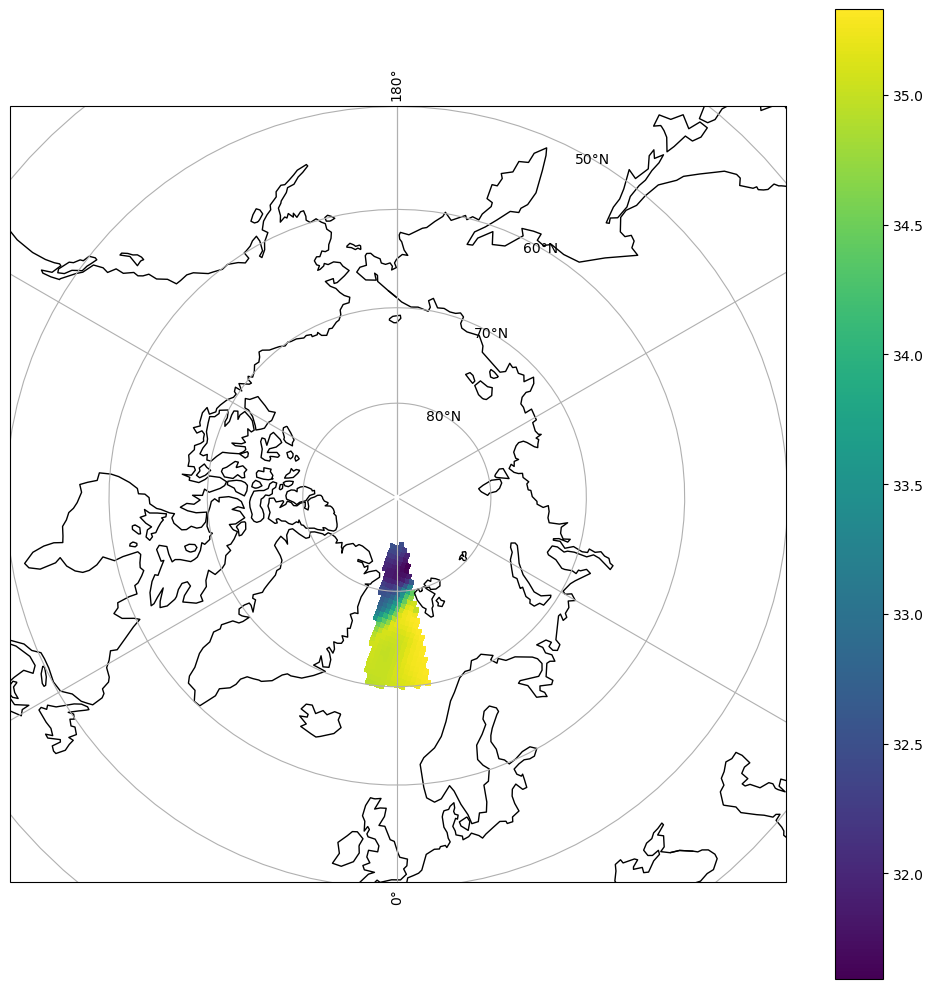

In [43]:
f.PlotModel(area.isel(time=0))

In [193]:
print(areacello.areacello.isel(i=300).isel(j=300))

<xarray.DataArray 'areacello' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    i          int32 300
    j          int32 300
    latitude   float32 dask.array<chunksize=(), meta=np.ndarray>
    longitude  float32 dask.array<chunksize=(), meta=np.ndarray>
    member_id  <U8 'r1i1p1f2'
Attributes:
    cell_methods:   area: sum
    comment:        Horizontal area of ocean grid cells
    long_name:      Grid-Cell Area for Ocean Variables
    original_name:  mo: (variable_name: areacello)
    standard_name:  cell_area
    units:          m2


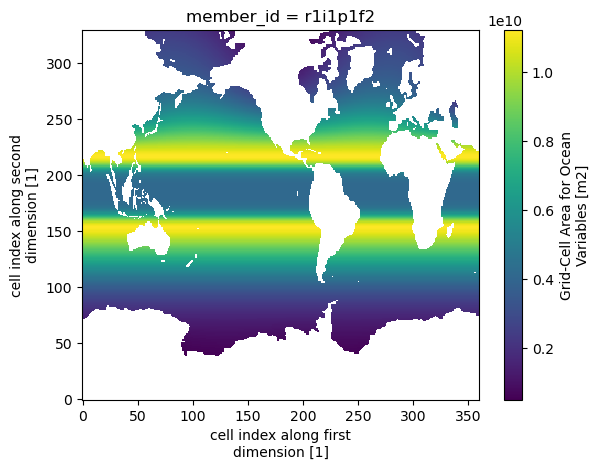

In [189]:
areacello.areacello.plot()

In [195]:
total_area = 1/np.sum(areacello['areacello'])

In [44]:
MDS.sel(time = '2010-01').sel(lev=0, method='nearest').sel(bnds=0).sel(vertices=0)

<xarray.Dataset>
Dimensions:             (i: 362, j: 332, time: 1)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 355 356 357 358 359 360 361
  * j                   (j) int32 0 1 2 3 4 5 6 ... 325 326 327 328 329 330 331
    latitude            (j, i) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    lev                 float64 0.5058
    lev_bnds            float64 dask.array<chunksize=(), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time                (time) object 2010-01-16 00:00:00
    time_bnds           (time) object dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    so                  (time, j, i) float32 dask.array<chunksize=(1, 332, 362), meta=np.ndarray>
    vertices_latitude   (j, i) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    vertices_longitude  (j, i) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
Attributes: (12/52)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    cmor_version:            3.4.0
    ...                      ...
    variable_name:           so
    variant_label:           r13i1p1f2
    netcdf_tracking_ids:     hdl:21.14100/b499c8b0-2082-43db-a178-90cb7d23afd...
    version_id:              v20200805
    intake_esm_varname:      ['so']
    intake_esm_dataset_key:  CMIP.NIMS-KMA.UKESM1-0-LL.historical.Omon.gn

In [45]:
MDS.sel(time = slice('1980','2020')).sel(lev=200, method='nearest').sel(bnds=0).sel(vertices=0)

<xarray.Dataset>
Dimensions:             (i: 362, j: 332, time: 420)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 355 356 357 358 359 360 361
  * j                   (j) int32 0 1 2 3 4 5 6 ... 325 326 327 328 329 330 331
    latitude            (j, i) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    lev                 float64 199.8
    lev_bnds            float64 dask.array<chunksize=(), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time                (time) object 1980-01-16 00:00:00 ... 2014-12-16 00:0...
    time_bnds           (time) object dask.array<chunksize=(420,), meta=np.ndarray>
Data variables:
    so                  (time, j, i) float32 dask.array<chunksize=(5, 332, 362), meta=np.ndarray>
    vertices_latitude   (j, i) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    vertices_longitude  (j, i) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
Attributes: (12/52)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    cmor_version:            3.4.0
    ...                      ...
    variable_name:           so
    variant_label:           r13i1p1f2
    netcdf_tracking_ids:     hdl:21.14100/b499c8b0-2082-43db-a178-90cb7d23afd...
    version_id:              v20200805
    intake_esm_varname:      ['so']
    intake_esm_dataset_key:  CMIP.NIMS-KMA.UKESM1-0-LL.historical.Omon.gn

In [47]:

#this is wrong area, need to cut stuff!!!

mean = MDS.sel(time = slice('1980','2020')).sel(lev=200, method='nearest').sel(bnds=0).sel(vertices=0).groupby('time.month').mean('time').mean('i').mean('j').compute()
print(mean)
mean
"""
std = ds.groupby('time.month').std('time').std('i').std('j')
#print(std)
t = ds.mean('i').mean('j').compute().groupby('time.month')
month = ds['time.month']
years = np.arange(1950,2015,1)
x = np.arange(1,13,1)

fig, ax = plt.subplots()
max_ = []
min_ = []
#for month in t.groups.keys():
#    max_.append(np.max(t[month]))
#    min_.append(np.min(t[month]))
#ax.fill_between(x, min_, max_, color='seashell')
#for month in t.groups.keys():
    #m = np.full(len(t[month]), month)
    #plt.scatter(m, t[month], color='peachpuff')
plt.plot(x, mean, 'cadetblue', lw=5)
#plt.plot(x, mean-std)
#plt.plot(x, mean+std)
plt.grid()
ticks = [1,2,3,4,5,6,7,8,9,10,11,12]

dic = { 1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
plt.title(f'Seasonality of Ocean Salinity at {ds.lev:.2f}m depth')
plt.show()
"""

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


<xarray.Dataset>
Dimensions:             (month: 12)
Coordinates:
    lev                 float64 199.8
    lev_bnds            float64 189.9
  * month               (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    so                  (month) float32 34.57 34.57 34.57 ... 34.58 34.58 34.58
    vertices_latitude   (month) float32 -11.22 -11.22 -11.22 ... -11.22 -11.22
    vertices_longitude  (month) float32 -0.1559 -0.1559 ... -0.1559 -0.1559


"\nstd = ds.groupby('time.month').std('time').std('i').std('j')\n#print(std)\nt = ds.mean('i').mean('j').compute().groupby('time.month')\nmonth = ds['time.month']\nyears = np.arange(1950,2015,1)\nx = np.arange(1,13,1)\n\nfig, ax = plt.subplots()\nmax_ = []\nmin_ = []\n#for month in t.groups.keys():\n#    max_.append(np.max(t[month]))\n#    min_.append(np.min(t[month]))\n#ax.fill_between(x, min_, max_, color='seashell')\n#for month in t.groups.keys():\n    #m = np.full(len(t[month]), month)\n    #plt.scatter(m, t[month], color='peachpuff')\nplt.plot(x, mean, 'cadetblue', lw=5)\n#plt.plot(x, mean-std)\n#plt.plot(x, mean+std)\nplt.grid()\nticks = [1,2,3,4,5,6,7,8,9,10,11,12]\n\ndic = { 1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}\nlabels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]\nax.set_xticks(ticks)\nax.set_xticklabels(labels)\nplt.title(f'Seasonality of Ocean Salinity at {ds.lev:.2f}m dep

In [49]:
mean

<xarray.Dataset>
Dimensions:             (month: 12)
Coordinates:
    lev                 float64 199.8
    lev_bnds            float64 189.9
  * month               (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    so                  (month) float32 34.57 34.57 34.57 ... 34.58 34.58 34.58
    vertices_latitude   (month) float32 -11.22 -11.22 -11.22 ... -11.22 -11.22
    vertices_longitude  (month) float32 -0.1559 -0.1559 ... -0.1559 -0.1559

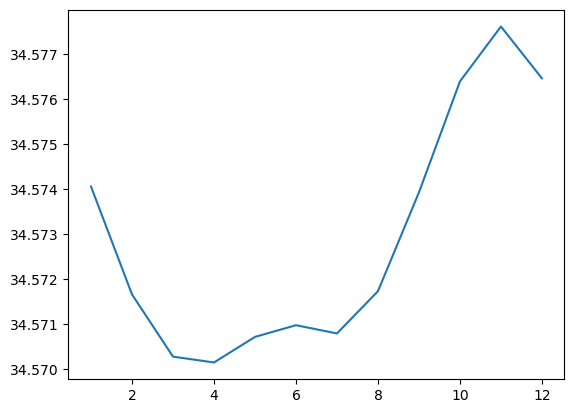

In [50]:
x = np.arange(1,13)
plt.plot(x, mean['so'])

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


<xarray.Dataset>
Dimensions:             (month: 12)
Coordinates:
    lev                 float64 199.8
    lev_bnds            float64 189.9
  * month               (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    so                  (month) float32 34.57 34.57 34.57 ... 34.58 34.58 34.58
    vertices_latitude   (month) float32 -11.22 -11.22 -11.22 ... -11.22 -11.22
    vertices_longitude  (month) float32 -0.1559 -0.1559 ... -0.1559 -0.1559


TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_array()` method.

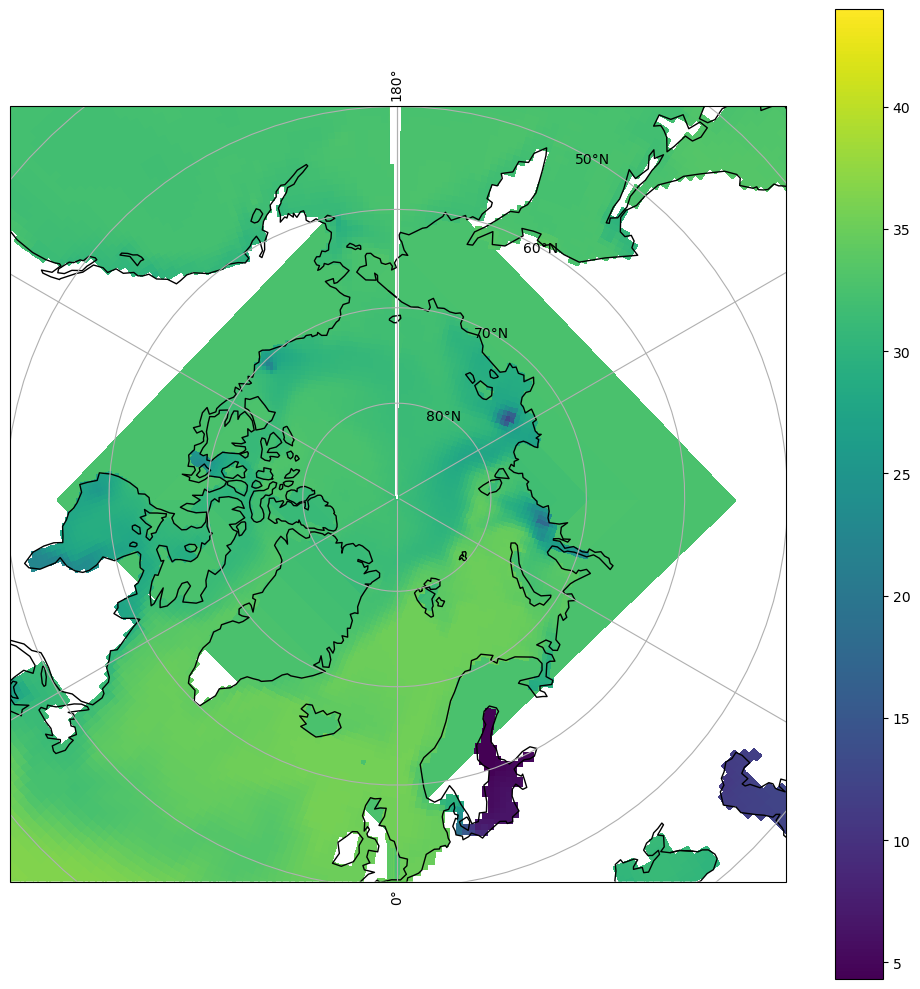

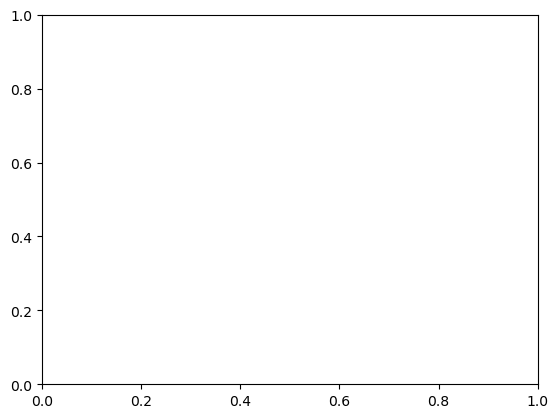

In [40]:
# Do a weighted mean with areacello
f.PlotModel(MDS.sel(time = '2010-01').sel(lev=0, method='nearest').sel(bnds=0).sel(vertices=0).squeeze())
#f.PlotSeasonality(MDS.sel(time = slice('1980','2020')).sel(lev=0, method='nearest').sel(bnds=0).sel(vertices=0))
f.PlotSeasonality(MDS.sel(time = slice('1980','2020')).sel(lev=200, method='nearest').sel(bnds=0).sel(vertices=0))


In [ ]:
last30 = MDS.sel(time=slice('1980', '2010')).sel(lev=0, method='nearest').sel(bnds=0).sel(vertices=0)
clm = MDS.sel(time=slice('1850', '1880')).sel(lev=0, method='nearest').sel(bnds=0).sel(vertices=0)

last30 = f.slice_data(last30, min_lat = 65, max_lat = 80, min_lon = -20, max_lon = 5)
clm = f.slice_data(clm, min_lat = 65, max_lat = 80, min_lon = -20, max_lon = 5)

last30 = last30.mean('time').compute()
clm = clm.mean('time').compute()

In [ ]:
anomaly=last30-clm
last30
f.PlotModel(anomaly, extent=[-22,12,60,85])

In [64]:
ts = area['so'].mean('i').mean('j').compute().groupby('time.year')

In [65]:
yearly_mean = ts.mean('time')
yearly_mean

<xarray.DataArray 'so' (year: 35)>
array([33.99927 , 34.125195, 34.182453, 33.999912, 33.84277 , 33.811893,
       33.64894 , 33.695087, 33.84728 , 33.86336 , 34.111546, 34.057114,
       33.88019 , 33.670437, 33.665234, 33.83403 , 33.836575, 33.783707,
       34.070805, 34.238132, 34.25995 , 34.178173, 34.102886, 33.96339 ,
       33.98372 , 33.992275, 33.954357, 33.980373, 33.8844  , 34.059135,
       34.141087, 34.147305, 34.045933, 33.836517, 33.361206],
      dtype=float32)
Coordinates:
    lev_bnds   float64 0.0
    member_id  <U8 'r2i1p1f2'
    lev        float64 0.5058
  * year       (year) int64 1980 1981 1982 1983 1984 ... 2011 2012 2013 2014

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]


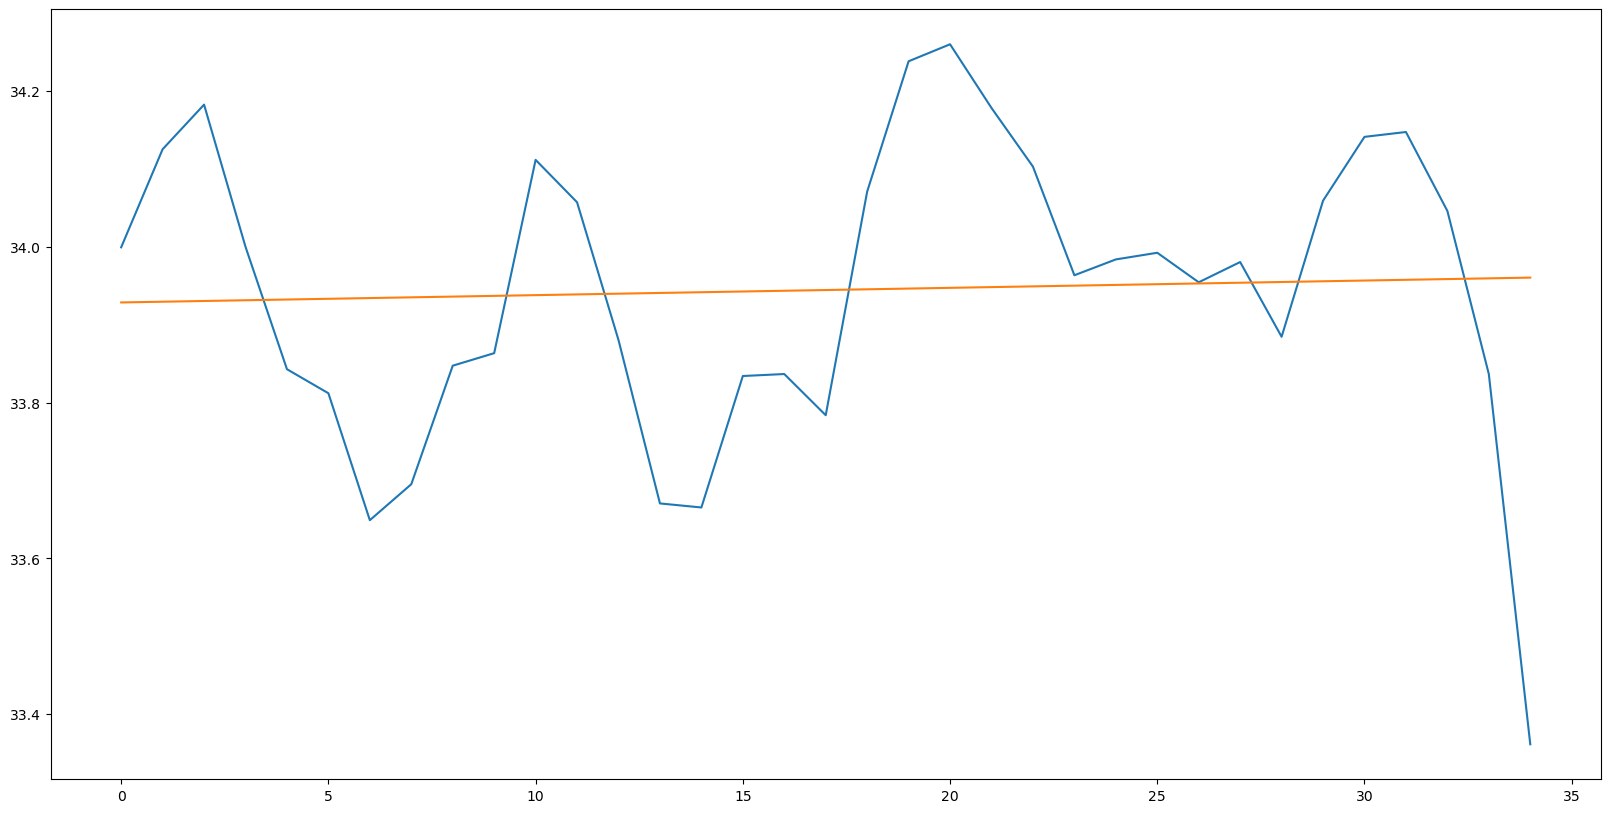

In [66]:
x = np.arange(len(yearly_mean))
print(x)
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(x,yearly_mean)
res = stats.linregress(x,yearly_mean)
plt.plot(x, res.intercept + res.slope*x)

## Vertical Structure Model

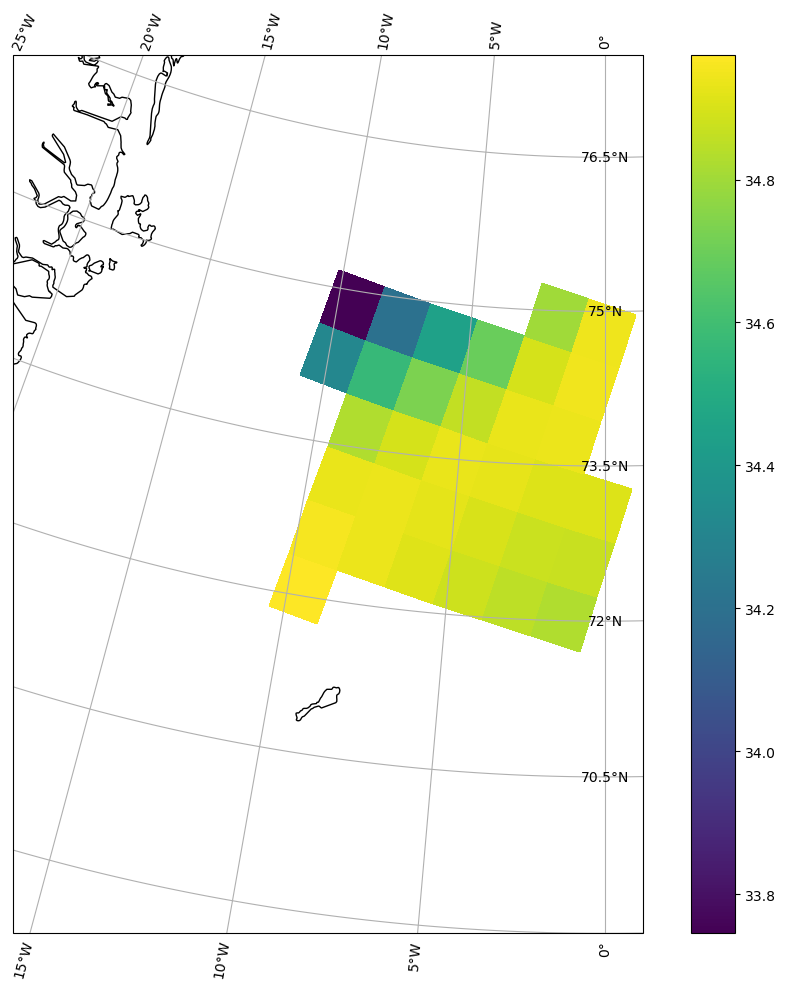

In [168]:
MDS
Vertical=MDS.sel(time=slice('2014-08', '2014-09')).sel(bnds=1).sel(vertices=0).squeeze()
#print(Vertical)
#Vertical = Vertical.sel(longitude=-3, method='nearest')
#Vertical = f.ConvertModelGrid(Vertical)
Vertical = Vertical.where(
    (Vertical['longitude'] < 0)
    & (Vertical['longitude'] > -10)
    & (Vertical['latitude'] < 75)
    & (Vertical['latitude'] > 72),
    drop=True)

f.PlotModel(Vertical.sel(lev=0, method='nearest').isel(time=0), extent=[-16,1,69,77])
#Mean vertical structure over an area

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


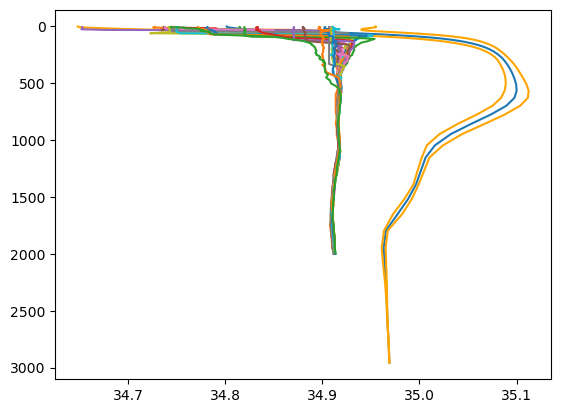

In [169]:
Vertical2 = Vertical.isel(lev=slice(0,60))
mean_structure=Vertical2['so'].mean('i').mean('j').mean('time')
std_structure=Vertical2['so'].std('i').std('j').mean('time')
fig, ax = plt.subplots()
plt.plot(mean_structure, Vertical2['lev'])
plt.plot(mean_structure-std_structure, Vertical2['lev'], color='orange')
plt.plot(mean_structure+std_structure, Vertical2['lev'], color='orange')
ax.invert_yaxis()
for i in range(len(Argo1['PSAL_ADJUSTED'])):
    plt.plot(Argo1['PSAL_ADJUSTED'][i], Argo1['PRES'][i])